In [5]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('Sales_Dataset.csv', 'Sales_Dataset') # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='123456',
    database='amazon'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Sanika Jadhav/OneDrive/Desktop/Amazon_Salesdata'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing Sales_Dataset.csv
NaN values before replacement:
Custkey                                0
DateKey                                0
Discount Amount                        2
Invoice Date                           0
Invoice Number                         0
Item Class                          8285
Item Number                           40
Item                                   0
Line Number                            0
List Price                             0
Order Number                           0
Promised Delivery Date                 0
Sales Amount                           0
Sales Amount Based on List Price       0
Sales Cost Amount                      0
Sales Margin Amount                    0
Sales Price                            1
Sales Quantity                         0
Sales Rep                              0
U/M                                    0
dtype: int64



In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector

db=mysql.connector.connect(host="localhost",
                           username="root",
                           password="123456",
                           database="amazon")

cur = db.cursor()


In [15]:
cur.execute("DESCRIBE sales_dataset;")
columns = cur.fetchall()
for column in columns:
    print(column)

('Custkey', 'int', 'YES', '', None, '')
('DateKey', 'text', 'YES', '', None, '')
('Discount_Amount', 'float', 'YES', '', None, '')
('Invoice_Date', 'text', 'YES', '', None, '')
('Invoice_Number', 'int', 'YES', '', None, '')
('Item_Class', 'text', 'YES', '', None, '')
('Item_Number', 'text', 'YES', '', None, '')
('Item', 'text', 'YES', '', None, '')
('Line_Number', 'int', 'YES', '', None, '')
('List_Price', 'float', 'YES', '', None, '')
('Order_Number', 'int', 'YES', '', None, '')
('Promised_Delivery_Date', 'text', 'YES', '', None, '')
('Sales_Amount', 'float', 'YES', '', None, '')
('Sales_Amount_Based_on_List_Price', 'float', 'YES', '', None, '')
('Sales_Cost_Amount', 'float', 'YES', '', None, '')
('Sales_Margin_Amount', 'float', 'YES', '', None, '')
('Sales_Price', 'float', 'YES', '', None, '')
('Sales_Quantity', 'int', 'YES', '', None, '')
('Sales_Rep', 'int', 'YES', '', None, '')
('U/M', 'text', 'YES', '', None, '')


In [3]:
#List the food products present in the dataset
query = """ select distinct(Item) from sales_dataset """
cur.execute(query)
data =  cur.fetchall()
data

[('Super Vegetable Oil',),
 ('Golden Fajita French Fries',),
 ('High Top Oranges',),
 ('Tell Tale New Potatos',),
 ('BBB Best Creamy Peanut Butter',),
 ('BBB Best Apple Preserves',),
 ('Better Fancy Canned Sardines',),
 ('Better Rice Soup',),
 ('Monarch Spaghetti',),
 ('Swell Canned Peaches',),
 ('Moms Cole Slaw',),
 ('Washington Cranberry Juice',),
 ('Fast Lemon Cookies',),
 ('Walrus Chardonnay',),
 ('Fast Frosted Cookies',),
 ('Ebony Lemons',),
 ('Club String Cheese',),
 ('Monarch Ravioli',),
 ('BBB Best Strawberry Preserves',),
 ('Even Better Chocolate Milk',),
 ('Ebony Prepared Salad',),
 ('Moms Sliced Ham',),
 ('Fabulous Diet Soda',),
 ('Fast Buttered Popcorn',),
 ('American Pimento Loaf',),
 ('Cutting Edge Cole Slaw',),
 ('Nationeel Beef Jerky',),
 ('Even Better Strawberry Yogurt',),
 ('Super Creamy Peanut Butter',),
 ('Ebony Squash',),
 ('Great Muffins',),
 ('Tell Tale Limes',),
 ('Big Time Frozen Cheese Pizza',),
 ('Bravo Canned Yams',),
 ('Nationeel Salted Pretzels',),
 ('High

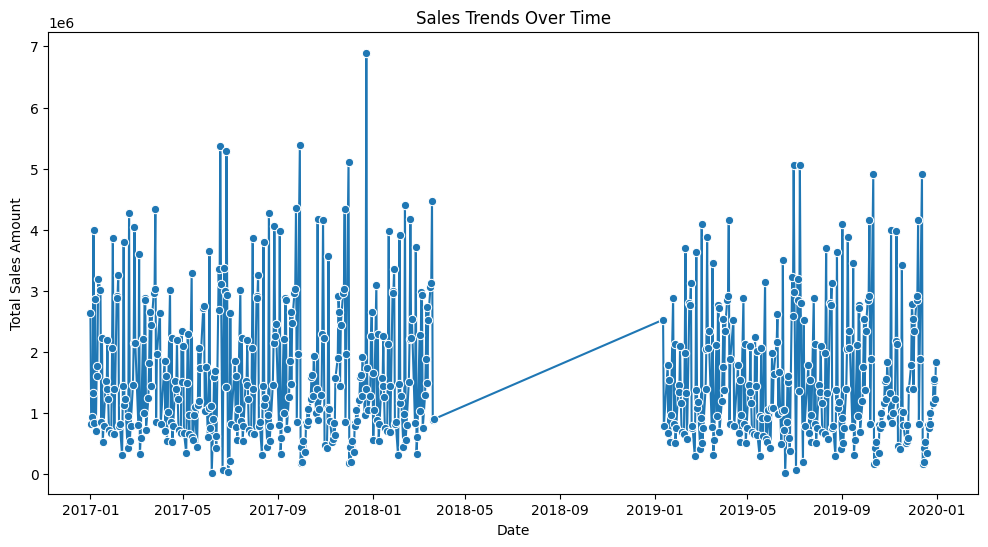

In [6]:
#sales trends over time
query = """
SELECT DateKey, SUM(Sales_Amount) AS Total_Sales
FROM sales_dataset
GROUP BY DateKey
ORDER BY DateKey
"""
cur.execute(query)
sales_trends_data = cur.fetchall()

# Convert the fetched data into a pandas DataFrame
sales_trends_df = pd.DataFrame(sales_trends_data, columns=['DateKey', 'Total_Sales'])

# Convert DateKey to datetime, allowing for mixed formats
sales_trends_df['DateKey'] = pd.to_datetime(sales_trends_df['DateKey'], format='mixed', errors='coerce')

# Check for parsing issues
if sales_trends_df['DateKey'].isna().any():
    print("Failed to parse some dates. Showing problematic rows:")
    print(sales_trends_df[sales_trends_df['DateKey'].isna()])

# Drop rows with invalid dates (optional)
sales_trends_df = sales_trends_df.dropna(subset=['DateKey'])

# Plot the sales trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=sales_trends_df, x='DateKey', y='Total_Sales', marker='o')
plt.title('Sales Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.show()


C:\Users\Sanika Jadhav\AppData\Local\Temp\ipykernel_26480\2666610618.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_price_df, x='Avg_Price', y='Item', palette='Blues_r')


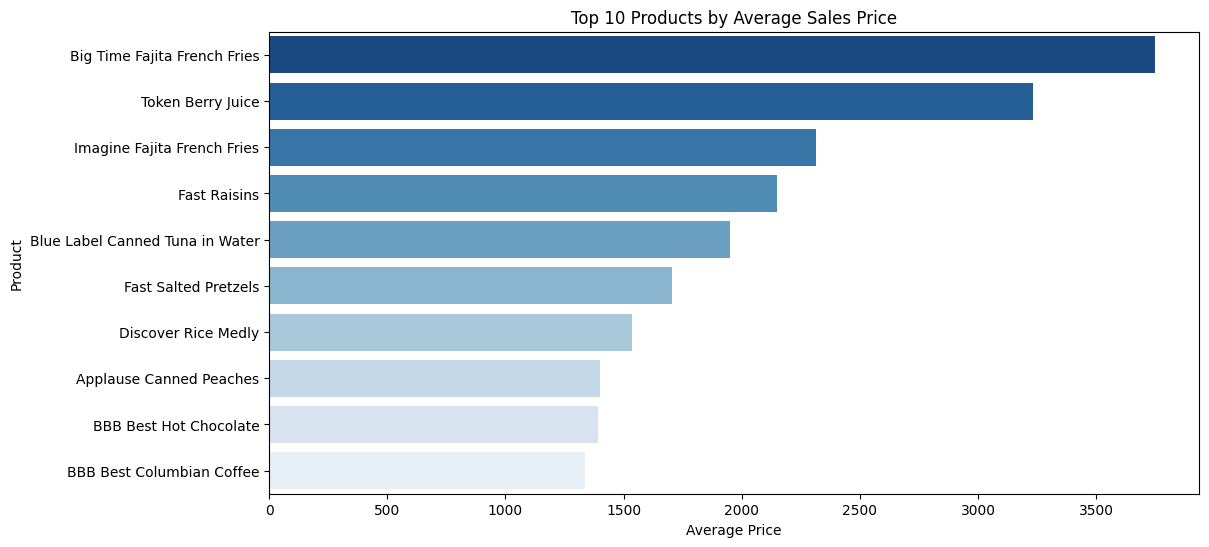

In [7]:
#average sales by product
query = """
SELECT Item, AVG(Sales_Price) AS Avg_Price
FROM sales_dataset
GROUP BY Item
ORDER BY Avg_Price DESC
LIMIT 10
"""
cur.execute(query)
avg_price_data = cur.fetchall()
avg_price_df = pd.DataFrame(avg_price_data, columns=['Item', 'Avg_Price'])

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_price_df, x='Avg_Price', y='Item', palette='Blues_r')
plt.title('Top 10 Products by Average Sales Price')
plt.xlabel('Average Price')
plt.ylabel('Product')
plt.show()


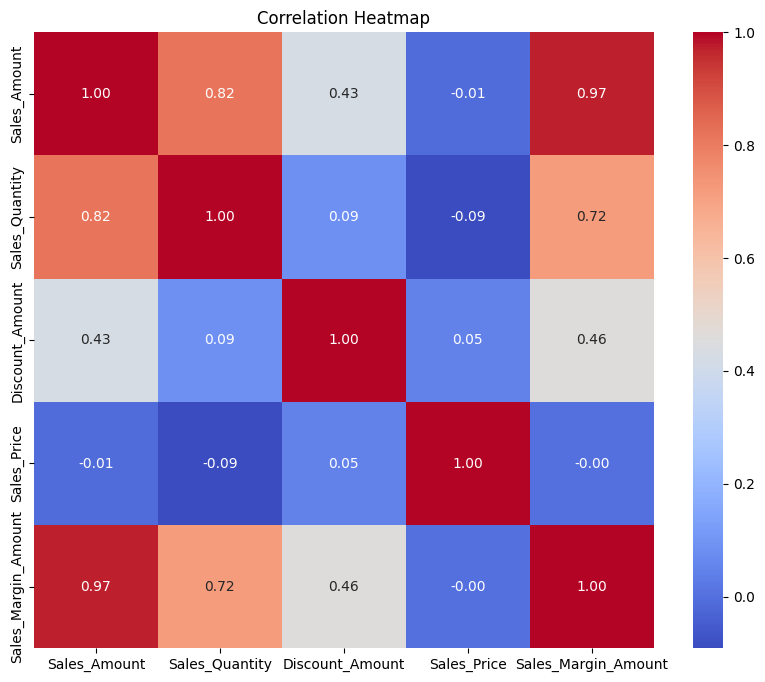

In [9]:
#Correlation Heatmap of Numeric Features
query = """
SELECT Sales_Amount, Sales_Quantity, Discount_Amount, Sales_Price, Sales_Margin_Amount
FROM sales_dataset
"""
cur.execute(query)
correlation_data = cur.fetchall()
correlation_df = pd.DataFrame(correlation_data, columns=['Sales_Amount', 'Sales_Quantity', 'Discount_Amount', 'Sales_Price', 'Sales_Margin_Amount'])

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


C:\Users\Sanika Jadhav\AppData\Local\Temp\ipykernel_26480\3341701519.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_items_df, x='Total_Quantity', y='Item', palette='Set2')


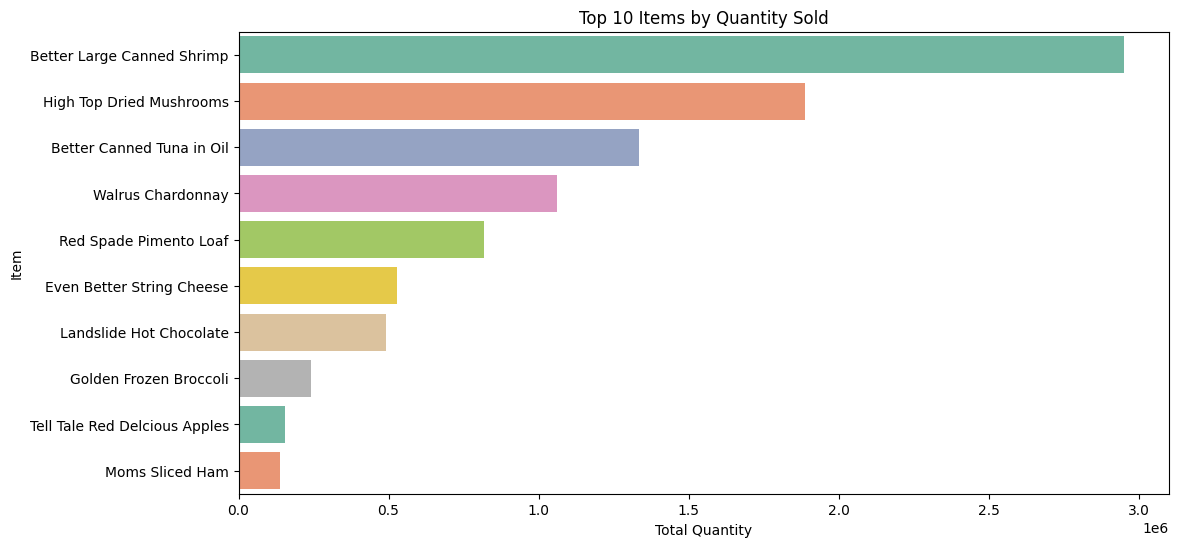

In [10]:
#Top 10 items via quantity sold
query = """
SELECT Item, SUM(Sales_Quantity) AS Total_Quantity
FROM sales_dataset
GROUP BY Item
ORDER BY Total_Quantity DESC
LIMIT 10
"""
cur.execute(query)
top_items_data = cur.fetchall()
top_items_df = pd.DataFrame(top_items_data, columns=['Item', 'Total_Quantity'])

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_items_df, x='Total_Quantity', y='Item', palette='Set2')
plt.title('Top 10 Items by Quantity Sold')
plt.xlabel('Total Quantity')
plt.ylabel('Item')
plt.show()


C:\Users\Sanika Jadhav\AppData\Local\Temp\ipykernel_22384\2612207360.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=profit_margin_df, x='Avg_Profit_Margin', y='Item', palette='coolwarm')


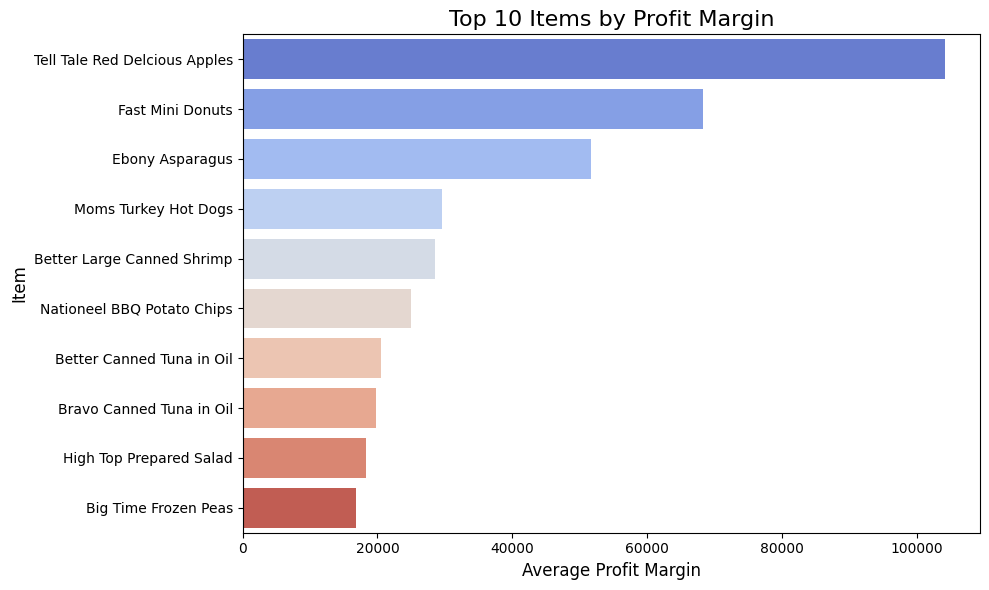

In [11]:
#Top 10 Items by profit marging
query = """
SELECT Item, AVG(Sales_Margin_Amount) AS Avg_Profit_Margin
FROM sales_dataset
GROUP BY Item
ORDER BY Avg_Profit_Margin DESC
LIMIT 10;
"""
cur.execute(query)
profit_margin_data = cur.fetchall()
profit_margin_df = pd.DataFrame(profit_margin_data, columns=['Item', 'Avg_Profit_Margin'])

# Plot profit margin analysis
plt.figure(figsize=(10, 6))
sns.barplot(data=profit_margin_df, x='Avg_Profit_Margin', y='Item', palette='coolwarm')
plt.title('Top 10 Items by Profit Margin', fontsize=16)
plt.xlabel('Average Profit Margin', fontsize=12)
plt.ylabel('Item', fontsize=12)
plt.tight_layout()
plt.show()


C:\Users\Sanika Jadhav\AppData\Local\Temp\ipykernel_22384\3644436362.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_items_df, x='Total_Quantity', y='Item', palette='viridis')


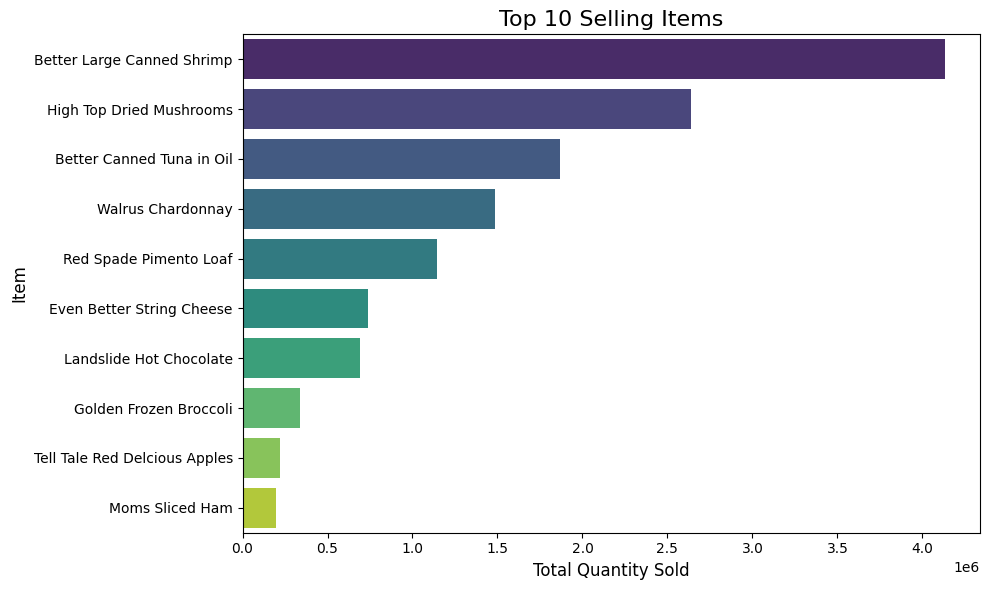

In [10]:
#Top 10 selling items
query = """
SELECT Item, SUM(Sales_Quantity) AS Total_Quantity
FROM sales_dataset
GROUP BY Item
ORDER BY Total_Quantity DESC
LIMIT 10;
"""
cur.execute(query)
top_items_data = cur.fetchall()
top_items_df = pd.DataFrame(top_items_data, columns=['Item', 'Total_Quantity'])

# Plot top selling items
plt.figure(figsize=(10, 6))
sns.barplot(data=top_items_df, x='Total_Quantity', y='Item', palette='viridis')
plt.title('Top 10 Selling Items', fontsize=16)
plt.xlabel('Total Quantity Sold', fontsize=12)
plt.ylabel('Item', fontsize=12)
plt.tight_layout()
plt.show()


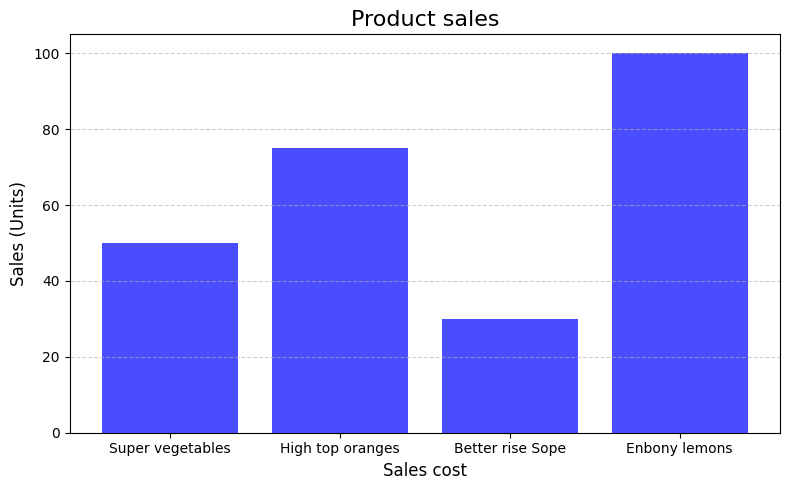

In [5]:
import matplotlib.pyplot as plt

# Example data
categories = ['Super vegetables', 'High top oranges', 'Better rise Sope', 'Enbony lemons']
values = [50, 75, 30, 100]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(categories, values, color='blue', alpha=0.7)

# Customize the chart
plt.title('Product sales', fontsize=16)
plt.xlabel('Sales cost', fontsize=12)
plt.ylabel('Sales (Units)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show the chart
plt.tight_layout()
plt.show()


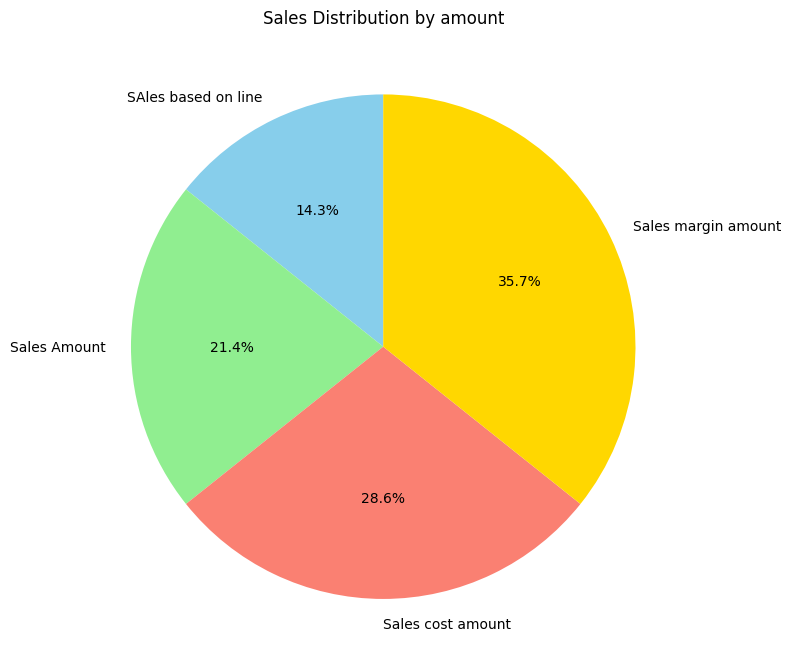

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample sales data
data = pd.DataFrame({
    'Product': ['Sales Amount', 'Sales cost amount ', 'SAles based on line', 'Sales margin amount'],
    'Sales': [150, 200, 100, 250]
})

# Summing sales by product (if needed)
sales_by_product = data.groupby('Product')['Sales'].sum()

# Create a pie chart
plt.figure(figsize=(8, 8))
sales_by_product.plot(
    kind='pie',
    autopct='%1.1f%%',  # Display percentage
    startangle=90,      # Rotate the chart
    colors=['skyblue', 'lightgreen', 'salmon', 'gold']
)

# Customize the chart
plt.title('Sales Distribution by amount')
plt.ylabel('')  # Remove default ylabel

# Show the plot
plt.tight_layout()
plt.show()



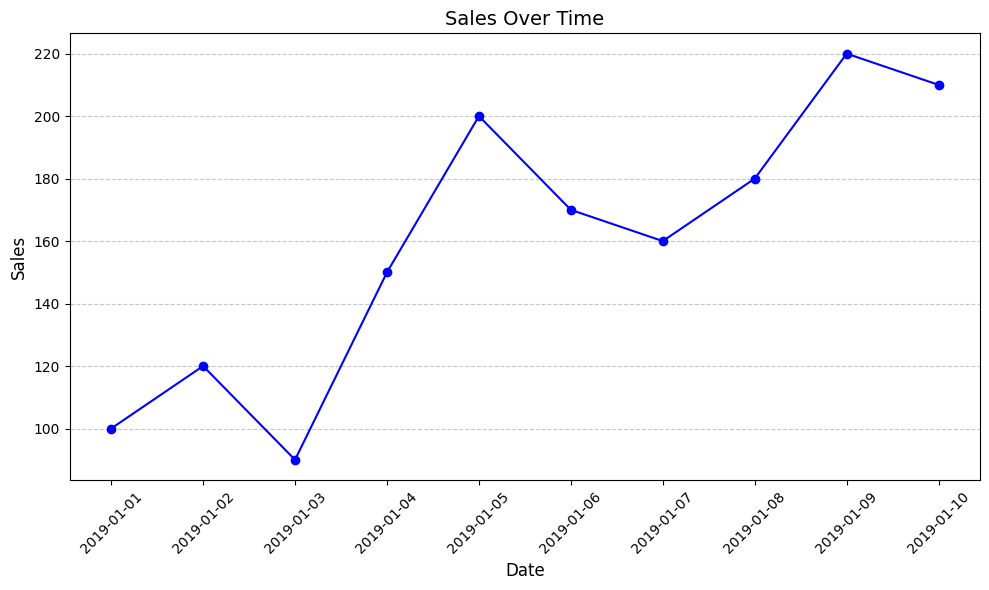

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data for sales over time
data = pd.DataFrame({
    'Date': pd.date_range(start='2019', periods=10, freq='D'),
    'Sales': [100, 120, 90, 150, 200, 170, 160, 180, 220, 210]
})

# Convert 'Date' column to datetime format (if not already)
data['Date'] = pd.to_datetime(data['Date'])

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Sales'], color='blue', marker='o', linestyle='-')

# Customize the chart
plt.title('Sales Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


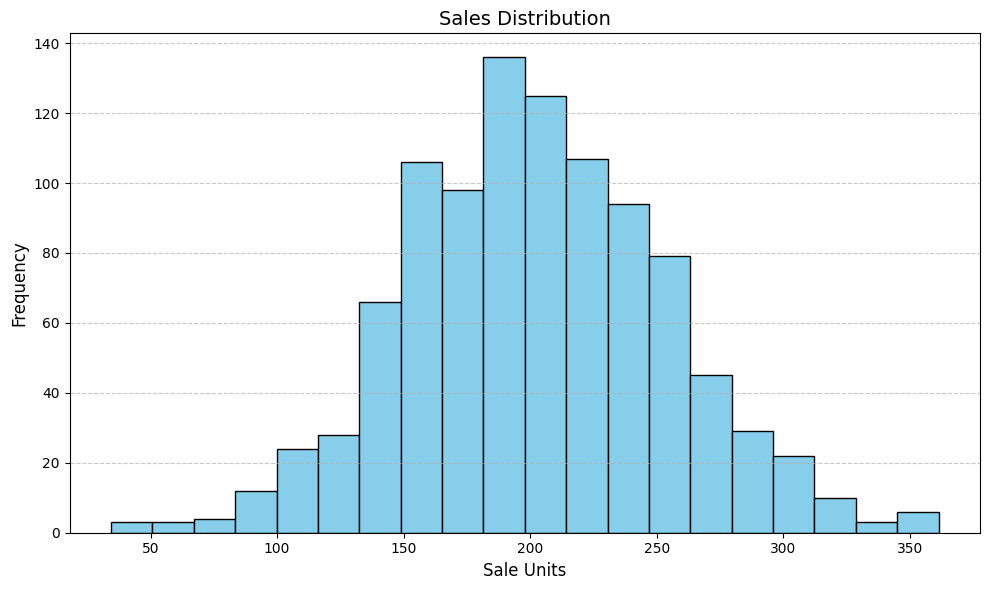

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
sales_data = np.random.normal(loc=200, scale=50, size=1000)  

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(sales_data, bins=20, color='skyblue', edgecolor='black')

# Customize the chart
plt.title('Sales Distribution', fontsize=14)
plt.xlabel('Sale Units', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


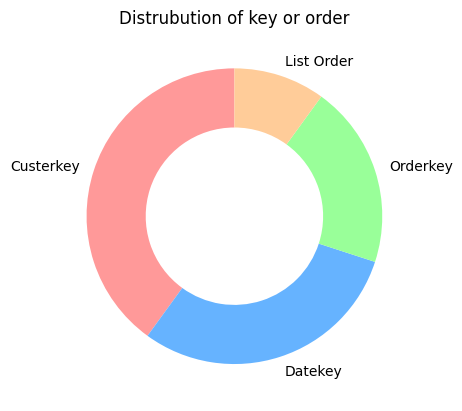

In [35]:
import matplotlib.pyplot as plt

# Example data: Market share of companies
labels = ['Custerkey', 'Datekey', 'Orderkey', 'List Order']
sizes = [40, 30, 20, 10]  # Market share percentages
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']  # Colors for each segment

# Creating the doughnut chart
plt.pie(sizes, labels=labels, colors=colors, startangle=90, wedgeprops={'width': 0.4})

# Adding title
plt.title('Distrubution of key or order')

# Display the plot
plt.show()


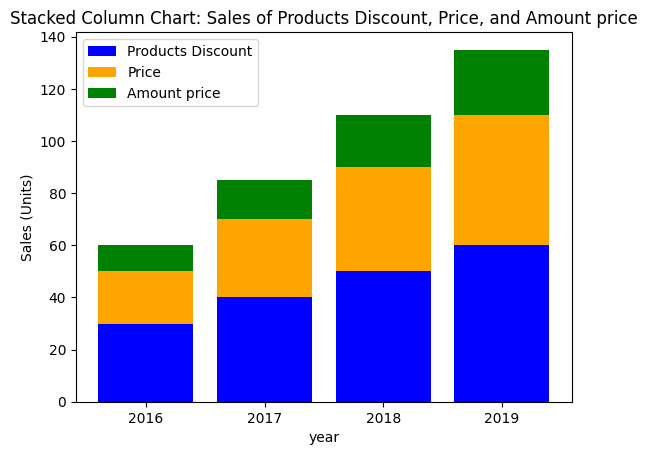

In [31]:
import matplotlib.pyplot as plt

# Example data: Sales of three products across four months
year = ['2016', '2017', '2018', '2019']
product_a_sales = [30, 40, 50, 60]
product_b_sales = [20, 30, 40, 50]
product_c_sales = [10, 15, 20, 25]

# Plotting the stacked column chart
plt.bar(year, product_a_sales, label='Products Discount', color='blue')
plt.bar(year, product_b_sales, bottom=product_a_sales, label='Price', color='orange')
plt.bar(year, product_c_sales, bottom=[i+j for i,j in zip(product_a_sales, product_b_sales)], label='Amount price', color='green')

# Adding title and labels
plt.title('Stacked Column Chart: Sales of Products Discount, Price, and Amount price')
plt.xlabel('year')
plt.ylabel('Sales (Units)')

# Adding legend
plt.legend()

# Display the plot
plt.show()


**Conclusion**
1.Based on the analysis, the dataset reveals significant insights into sales trends across regions, products, and time periods. 
2. Key observations include high-performing products and regions contributing to the majority of sales, alongside seasonal 
variations influencing sales trends. 
3.The analysis highlights the potential for optimizing discount strategies and identifying areas for improved marketing efforts.